STEP 6

Like
-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: count, dtype: int64
Like_n
 4    229
 5    187
-2    169
 3    160
 6    152
-3    152
-4    143
 0     73
-1     71
 1     59
 2     58
Name: count, dtype: int64
Q("Like_n") ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting
Best GMM Model: GaussianMixture(n_components=2, random_state=1234)
                            OLS Regression Results                            
Dep. Variable:            Q("Like_n")   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     24.12
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           4.32e-46
Time:                   

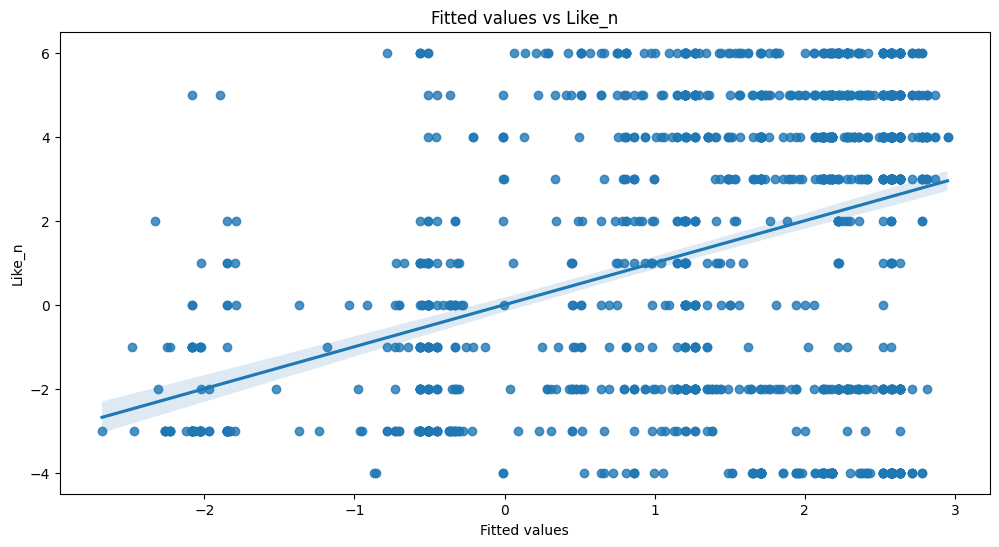

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from statsmodels.formula.api import ols
import patsy

# Load the dataset
file_path = '/content/drive/MyDrive/Code Conversion/mcdonalds.csv'
mcdonalds = pd.read_csv(file_path)

# Convert the first 11 columns to a binary matrix
MD_x = mcdonalds.iloc[:, 0:11]
MD_x_binary = (MD_x == "Yes").astype(int)

# Reverse the table of 'Like'
like_counts = mcdonalds['Like'].value_counts()
print(like_counts[::-1])

# Create a new column 'Like_n' (replace '.' with '_' to avoid confusion)
mcdonalds['Like_n'] = 6 - mcdonalds['Like'].astype('category').cat.codes

# Check the table of 'Like_n'
like_n_counts = mcdonalds['Like_n'].value_counts()
print(like_n_counts)

# Create the formula (use 'Q' to quote column name with special character)
formula = 'Q("Like_n") ~ ' + ' + '.join(mcdonalds.columns[:11])
print(formula)

# Set the seed for reproducibility
np.random.seed(1234)

# Fit the regression model using Gaussian Mixture Model
k = 2
n_repeats = 10
best_gmm = None
best_bic = np.inf

for _ in range(n_repeats):
    gmm = GaussianMixture(n_components=k, n_init=1, random_state=1234).fit(MD_x_binary)
    if gmm.bic(MD_x_binary) < best_bic:
        best_bic = gmm.bic(MD_x_binary)
        best_gmm = gmm

print("Best GMM Model:", best_gmm)

# Fit a linear regression model using statsmodels
y, X = patsy.dmatrices(formula, data=mcdonalds, return_type='dataframe') # Use the modified formula
model = ols(formula, data=mcdonalds).fit()
print(model.summary())

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot(x=model.fittedvalues, y=mcdonalds['Like_n'], ax=ax) # Access the column with the modified name
ax.set_xlabel('Fitted values')
ax.set_ylabel('Like_n')
ax.set_title('Fitted values vs Like_n')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-5-50048b1a9c20>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(MD_x_binary.shape[1]), y=kmeans.cluster_centers_.mean(axis=0)[feature_order], palette='viridis')


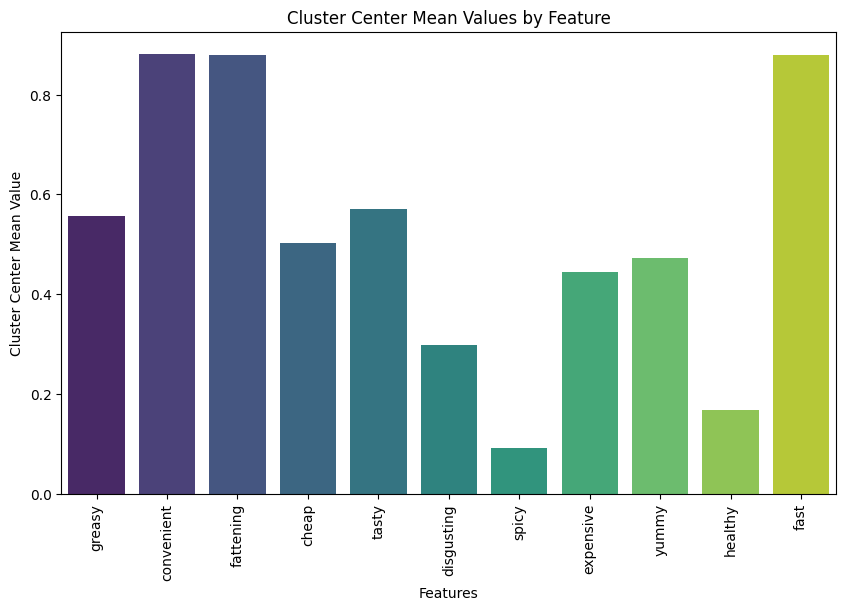

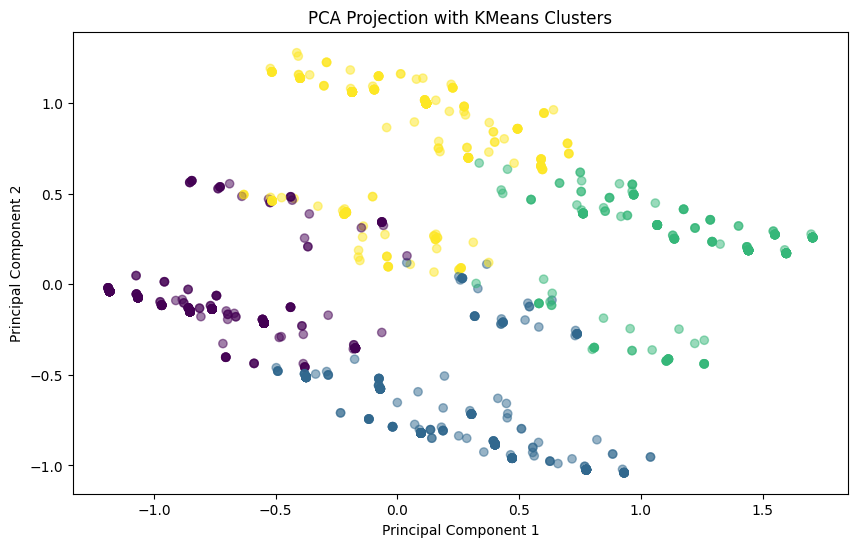

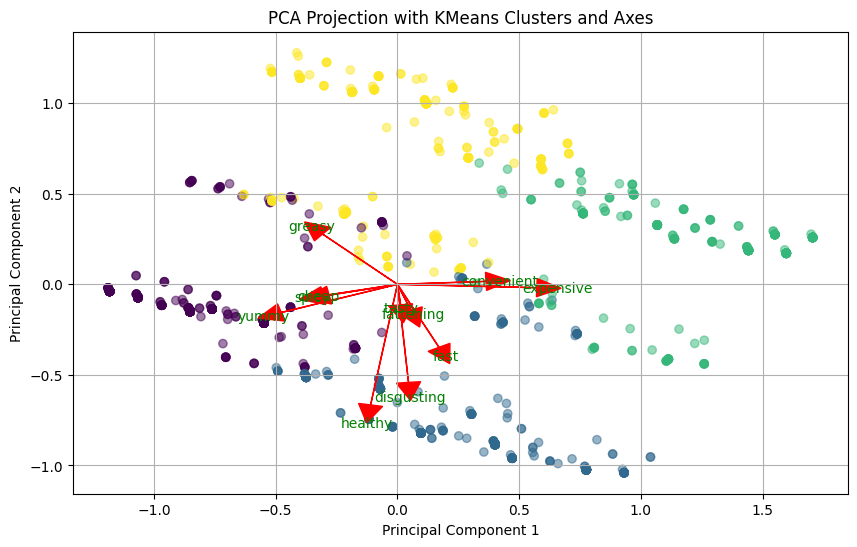

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the dataset
file_path = '/content/drive/MyDrive/Code Conversion/mcdonalds.csv'
mcdonalds = pd.read_csv(file_path)

# Convert the first 11 columns to a binary matrix
MD_x = mcdonalds.iloc[:, 0:11]
MD_x_binary = (MD_x == "Yes").astype(int)

# Perform PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x_binary)

# Hierarchical clustering
MD_vclust = linkage(pdist(MD_x_binary.T), method='ward')

# Create a bar chart
# Assuming MD_k4 refers to the best KMeans clustering with 4 segments
kmeans = KMeans(n_clusters=4, random_state=1234)
MD_k4 = kmeans.fit_predict(MD_x_binary)

# Order the features by the hierarchical clustering
dend = dendrogram(MD_vclust, no_plot=True) # Store the dendrogram object
feature_order = np.argsort(dend['leaves'])[::-1] # Use the leaves directly for ordering

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(MD_x_binary.shape[1]), y=kmeans.cluster_centers_.mean(axis=0)[feature_order], palette='viridis')
plt.xticks(ticks=np.arange(MD_x_binary.shape[1]), labels=MD_x.columns[feature_order], rotation=90)
plt.xlabel('Features')
plt.ylabel('Cluster Center Mean Value')
plt.title('Cluster Center Mean Values by Feature')
plt.show()

# Scatter plot of PCA results colored by KMeans clusters
plt.figure(figsize=(10, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c=MD_k4, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with KMeans Clusters')
plt.show()

# Projected axes of PCA
# Assuming projAxes(MD_pca) in R would add the axes to the plot
# Here we plot the axes vectors on top of the scatter plot
components = pca.components_

plt.figure(figsize=(10, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c=MD_k4, cmap='viridis', alpha=0.5)
for i, comp in enumerate(components):
    plt.arrow(0, 0, comp[0], comp[1], color='r', head_width=0.1, head_length=0.1)
    plt.text(comp[0] * 1.15, comp[1] * 1.15, MD_x.columns[i], color='g', ha='center', va='center')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with KMeans Clusters and Axes')
plt.grid()
plt.show()